In [1]:
import math
from datetime import datetime, timedelta

# --- Constants ---
# Communauto
COMMUNAUTO_PLANS = {
    "Open": {
        "subscription_annual": 0,
        "subscription_monthly": 0,
        "hourly_rate": 13.50,
        "daily_max_first": 55.00,
        "daily_max_additional": 50.00,
        "km_included_trip": 75,
        "km_rate_after_included": 0.27,
        "weekend_surcharge_hourly": 0.35,
        "weekend_surcharge_daily": 3.50,
        "bond": False,
        "km_tiers": None # Special case
    },
    "Open Plus": {
        "subscription_annual": 45.00,
        "subscription_monthly": 45.00 / 12, # Assuming annual can be broken down
        "hourly_rate": 6.85,
        "daily_max_first": 50.00,
        "daily_max_additional": 35.00,
        "km_tiers": [(50, 0.25), (float('inf'), 0.22)], # (up_to_km, rate)
        "weekend_surcharge_hourly": 0.35,
        "weekend_surcharge_daily": 3.50,
        "bond": False
    },
    "Value": {
        "subscription_annual": 45.00,
        "subscription_monthly": 45.00 / 12,
        "hourly_rate": 3.60,
        "daily_max_first": 30.00,
        "daily_max_additional": 30.00,
        "km_tiers": [(50, 0.45), (float('inf'), 0.32)],
        "weekend_surcharge_hourly": 0.35,
        "weekend_surcharge_daily": 3.50,
        "bond": True
    },
    "Value Plus": {
        "subscription_annual": 12.50 * 12,
        "subscription_monthly": 12.50,
        "hourly_rate": 3.20,
        "daily_max_first": 26.00,
        "daily_max_additional": 26.00,
        "km_tiers": [(50, 0.37), (float('inf'), 0.29)],
        "weekend_surcharge_hourly": 0.35,
        "weekend_surcharge_daily": 3.50,
        "bond": True
    },
    "Value Extra": {
        "subscription_annual": 30.00 * 12,
        "subscription_monthly": 30.00,
        "hourly_rate": 2.90,
        "daily_max_first": 23.00,
        "daily_max_additional": 23.00,
        "km_tiers": [(float('inf'), 0.29)], # Flat rate
        "weekend_surcharge_hourly": 0.35,
        "weekend_surcharge_daily": 3.50,
        "bond": True
    }
}

COMMUNAUTO_FLEX_RATES = {
    "per_minute": 0.41,
    "per_hour": 13.50,
    "max_day": 50.00,
    "km_included_trip": 75,
    "km_rate_after_included": 0.27
}

COMMUNAUTO_LONG_DISTANCE = {
    "low_season": { # Oct 16 - Jun 14
        "first_day": 40.00,
        "additional_day": 29.95,
        "per_week": 185.00
    },
    "high_season": { # Jun 15 - Oct 15
        "first_day": 50.00,
        "additional_day": 42.00,
        "per_week": 220.00
    },
    "km_rate_first_300_limit_km": 300,
    "km_rate_first_300": 0.23,
    "km_rate_after_300": 0.15,
    "additional_hour_rate": 15.00
}

COMMUNAUTO_WORKDAY_RATE = {
    "flat_fee_day": 22.00,
    "km_included": 40,
    "km_rate_extra": 0.32,
    "max_hours": 10
}

VEHICLE_SURCHARGES = {
    "standard": 1.0,
    "family": 1.10,
    "minivan": 1.15
}

# --- Communauto Pricer ---
class CommunautoPricer:
    def __init__(self, plan_name, vehicle_type="standard"):
        if plan_name not in COMMUNAUTO_PLANS:
            raise ValueError(f"Unknown plan: {plan_name}")
        self.plan_name = plan_name
        self.plan_details = COMMUNAUTO_PLANS[plan_name]
        self.vehicle_type = vehicle_type
        self.vehicle_surcharge_multiplier = VEHICLE_SURCHARGES.get(vehicle_type, 1.0)

    def _calculate_km_cost(self, km, plan_details_override=None):
        details = plan_details_override if plan_details_override else self.plan_details
        
        # Handle "Open" plan's specific KM rule first
        if self.plan_name == "Open" and not plan_details_override:
            if km <= details.get("km_included_trip", 0): # Use .get for safety
                return 0
            else:
                # Ensure km_rate_after_included exists, default to 0 if not (shouldn't happen for Open)
                rate = details.get("km_rate_after_included", 0)
                return (km - details["km_included_trip"]) * rate
        
        # For other plans or when Open Plus rates are used by Value plans
        cost = 0
        
        # Check if km_tiers exists and is iterable
        km_tiers_data = details.get("km_tiers") # Use .get()
        if km_tiers_data: # Check if it's not None and implicitly if it's iterable
            # Simpler logic for Communauto's specific tiering:
            if km_tiers_data[0][0] == float('inf'): # Flat rate (e.g., Value Extra)
                cost = km * km_tiers_data[0][1]
            else: # Assuming two tiers like Open Plus, Value, Value Plus
                # Ensure there are enough elements in km_tiers_data for safety
                if len(km_tiers_data) >= 2:
                    km_tier1_limit = km_tiers_data[0][0]
                    rate_tier1 = km_tiers_data[0][1]
                    rate_tier2 = km_tiers_data[1][1]

                    if km <= km_tier1_limit:
                        cost = km * rate_tier1
                    else:
                        cost = (km_tier1_limit * rate_tier1) + \
                            ((km - km_tier1_limit) * rate_tier2)
                elif len(km_tiers_data) == 1: # Fallback if only one tier defined somehow (should not be the case for these plans)
                    cost = km * km_tiers_data[0][1]

            return cost
        elif "km_included_trip" in details and "km_rate_after_included" in details:
            # Fallback for plans that might have km_included_trip but no tiers (like Open, but already handled)
            # This path should ideally not be hit for non-Open plans if constants are correct
            if km <= details["km_included_trip"]:
                return 0
            else:
                return (km - details["km_included_trip"]) * details["km_rate_after_included"]
        
        return 0 # Default if no km cost rules apply or km_tiers is None and not Open plan

    def _calculate_time_cost_round_trip(self, total_hours, is_saturday_sunday, plan_details_override=None):
        details = plan_details_override if plan_details_override else self.plan_details
        
        hourly_rate = details["hourly_rate"]
        daily_max_first = details["daily_max_first"]
        daily_max_additional = details["daily_max_additional"]

        if is_saturday_sunday:
            hourly_rate += details["weekend_surcharge_hourly"]
            daily_max_first += details["weekend_surcharge_daily"]
            daily_max_additional += details["weekend_surcharge_daily"]

        if total_hours <= 0: return 0

        days = math.floor(total_hours / 24)
        remaining_hours = total_hours % 24

        time_cost = 0

        if days == 0:
            time_cost = min(total_hours * hourly_rate, daily_max_first)
        else: # Multi-day
            time_cost += daily_max_first # Cost for the first day
            if days > 1:
                time_cost += (days - 1) * daily_max_additional # Cost for full additional days
            
            # Cost for the remaining hours of the last partial day
            if remaining_hours > 0:
                 # If a new day starts, it's capped at daily_max_additional
                time_cost += min(remaining_hours * hourly_rate, daily_max_additional)
        return time_cost

    def calculate_round_trip_rate(self, total_hours, km, is_saturday_sunday, plan_details_override=None):
        current_plan_details = plan_details_override if plan_details_override else self.plan_details
        
        time_cost = self._calculate_time_cost_round_trip(total_hours, is_saturday_sunday, current_plan_details)
        km_cost = self._calculate_km_cost(km, current_plan_details)
        
        base_cost = time_cost + km_cost
        return base_cost * (self.vehicle_surcharge_multiplier if not plan_details_override else 1.0) # Surcharge only if not an override

    def calculate_flex_rate(self, total_hours, km, apply_flex_pass_30min_credit=False):
        minutes = total_hours * 60
        if apply_flex_pass_30min_credit:
            minutes = max(0, minutes - 30)

        # Time cost for FLEX
        time_cost_flex = 0
        if minutes <= (COMMUNAUTO_FLEX_RATES["max_day"] / COMMUNAUTO_FLEX_RATES["per_minute"]): # Cheaper per minute up to a point
            time_cost_flex_minute = minutes * COMMUNAUTO_FLEX_RATES["per_minute"]
            time_cost_flex_hourly = math.ceil(minutes/60) * COMMUNAUTO_FLEX_RATES["per_hour"] # FLEX per hour rate
            time_cost_flex = min(time_cost_flex_minute, time_cost_flex_hourly)
        else: # Hourly or daily max
             time_cost_flex = math.ceil(minutes/60) * COMMUNAUTO_FLEX_RATES["per_hour"]
        
        # Apply daily max for FLEX
        num_days_for_flex = math.ceil(total_hours / 24) if total_hours > 0 else 1
        max_time_cost_flex = num_days_for_flex * COMMUNAUTO_FLEX_RATES["max_day"]
        time_cost_flex = min(time_cost_flex, max_time_cost_flex)


        # KM cost for FLEX
        km_cost_flex = 0
        if km > COMMUNAUTO_FLEX_RATES["km_included_trip"]:
            km_cost_flex = (km - COMMUNAUTO_FLEX_RATES["km_included_trip"]) * COMMUNAUTO_FLEX_RATES["km_rate_after_included"]
            
        base_cost = time_cost_flex + km_cost_flex
        return base_cost * self.vehicle_surcharge_multiplier

    def calculate_long_distance_rate(self, total_hours, km, trip_start_date=datetime.now()):
        if self.plan_name not in ["Value", "Value Plus", "Value Extra"]:
            return float('inf') # Not applicable

        # Determine season
        month = trip_start_date.month
        day = trip_start_date.day
        is_low_season = (month > 10 or (month == 10 and day >= 16)) or \
                        (month < 6 or (month == 6 and day <= 14))
        
        season_rates = COMMUNAUTO_LONG_DISTANCE["low_season"] if is_low_season else COMMUNAUTO_LONG_DISTANCE["high_season"]

        total_days_full = math.floor(total_hours / 24)
        extra_hours_last_day = total_hours % 24

        time_cost_ld = 0
        
        num_weeks = math.floor(total_days_full / 7)
        remaining_days_after_weeks = total_days_full % 7

        if num_weeks > 0:
            time_cost_ld += num_weeks * season_rates["per_week"]
        
        if remaining_days_after_weeks > 0:
            time_cost_ld += season_rates["first_day"] # For the first of the remaining days
            if remaining_days_after_weeks > 1:
                time_cost_ld += (remaining_days_after_weeks - 1) * season_rates["additional_day"]
        elif total_hours > 0 and num_weeks == 0 and total_days_full == 0 : # Less than 1 day trip
             time_cost_ld += season_rates["first_day"] # Minimum cost of first day
        
        if extra_hours_last_day > 0:
            if total_days_full == 0 and num_weeks == 0 : # Trip is less than 24h
                 # if total_hours make it cheaper than first_day rate (e.g. 1h @ $15/h vs $40 first_day)
                 cost_by_hours = extra_hours_last_day * COMMUNAUTO_LONG_DISTANCE["additional_hour_rate"]
                 time_cost_ld = min(cost_by_hours, season_rates["first_day"]) # capped by first_day rate
            else: # Trip is multi-day, these are hours on top of full days
                cost_for_extra_hours = extra_hours_last_day * COMMUNAUTO_LONG_DISTANCE["additional_hour_rate"]
                time_cost_ld += min(cost_for_extra_hours, season_rates["additional_day"])


        # KM cost for Long Distance
        km_cost_ld = 0
        if km <= COMMUNAUTO_LONG_DISTANCE["km_rate_first_300_limit_km"]: # Assuming a var for 300km
             km_cost_ld = km * COMMUNAUTO_LONG_DISTANCE["km_rate_first_300"]
        else:
            km_cost_ld = (COMMUNAUTO_LONG_DISTANCE["km_rate_first_300_limit_km"] * COMMUNAUTO_LONG_DISTANCE["km_rate_first_300"]) + \
                         ((km - COMMUNAUTO_LONG_DISTANCE["km_rate_first_300_limit_km"]) * COMMUNAUTO_LONG_DISTANCE["km_rate_after_300"])
        
        # Temp fix for km_rate_first_300_limit_km, hardcoding 300
        KM_LD_THRESHOLD = 300
        if km <= KM_LD_THRESHOLD:
             km_cost_ld = km * COMMUNAUTO_LONG_DISTANCE["km_rate_first_300"]
        else:
            km_cost_ld = (KM_LD_THRESHOLD * COMMUNAUTO_LONG_DISTANCE["km_rate_first_300"]) + \
                         ((km - KM_LD_THRESHOLD) * COMMUNAUTO_LONG_DISTANCE["km_rate_after_300"])

        base_cost = time_cost_ld + km_cost_ld
        return base_cost * self.vehicle_surcharge_multiplier

    def calculate_workday_rate(self, total_hours, km, is_weekday):
        if not (self.plan_name == "Value Extra" and is_weekday and total_hours <= COMMUNAUTO_WORKDAY_RATE["max_hours"]):
            return float('inf')

        # The "unbilled period from midnight to 6am" is tricky.
        # For simplicity, we assume `total_hours` is the billable duration as per their example logic.
        # If a trip is 5pm to 9am next day (16 hours), but only 10 are billable under Workday rules.
        # This estimator will assume `total_hours` is ALREADY the billable part.
        
        time_cost_wd = COMMUNAUTO_WORKDAY_RATE["flat_fee_day"]
        
        km_cost_wd = 0
        if km > COMMUNAUTO_WORKDAY_RATE["km_included"]:
            km_cost_wd = (km - COMMUNAUTO_WORKDAY_RATE["km_included"]) * COMMUNAUTO_WORKDAY_RATE["km_rate_extra"]
            
        base_cost = time_cost_wd + km_cost_wd
        return base_cost * self.vehicle_surcharge_multiplier

    def get_best_price(self, trip_type, total_hours, km, is_saturday_sunday, is_weekday, 
                         trip_start_date=datetime.now(), use_flex_pass=False):
        """
        trip_type: "round_trip" or "flex"
        is_saturday_sunday: boolean
        is_weekday: boolean (for Workday rate, typically Mon-Fri)
        """
        costs = {}

        # 1. Calculate cost using member's round-trip plan rates
        # For FLEX trips, if round-trip rate is applied, minimum 4 hours time charge
        rt_hours_for_comparison = total_hours
        if trip_type == "flex" and total_hours < 4:
            rt_hours_for_comparison = 4 
            # Small correction: the example states $2.90/hr x 4 hours.
            # This implies the hourly rate applies to the 4 hours, not just a flat 4*hourly.
            # The _calculate_time_cost_round_trip should handle this correctly if given 4 hours.

        cost_round_trip_plan = self.calculate_round_trip_rate(rt_hours_for_comparison, km, is_saturday_sunday)
        costs["PlanRate_RoundTrip"] = cost_round_trip_plan
        
        # 1a. For Value plans, check if Open Plus rates are cheaper (Quick Round-Trip Preferred Rate)
        if self.plan_name in ["Value", "Value Plus", "Value Extra"] and trip_type == "round_trip":
            # No minimum 4h here, this is for actual round-trip, not FLEX comparison
            cost_open_plus_rt = self.calculate_round_trip_rate(total_hours, km, is_saturday_sunday, 
                                                               plan_details_override=COMMUNAUTO_PLANS["Open Plus"])
            costs["PlanRate_OpenPlus_if_Cheaper"] = cost_open_plus_rt
            cost_round_trip_plan = min(cost_round_trip_plan, cost_open_plus_rt)
            costs["PlanRate_RoundTrip_AdjustedForOpenPlus"] = cost_round_trip_plan


        if trip_type == "flex":
            # 2. Calculate FLEX rate cost
            cost_flex_native = self.calculate_flex_rate(total_hours, km, apply_flex_pass_30min_credit=use_flex_pass)
            costs["FlexRate_Native"] = cost_flex_native
            
            # Final FLEX cost is minimum of its native rate and the (potentially 4h min) round-trip plan rate
            final_flex_cost = min(cost_flex_native, cost_round_trip_plan) # cost_round_trip_plan already has 4h min logic from above
            costs["Flex_FinalBilled"] = final_flex_cost
            chosen_cost = final_flex_cost
            chosen_method = "Flex (Min of Native Flex or Plan Rate)"

        else: # round_trip
            chosen_cost = cost_round_trip_plan 
            chosen_method = "RoundTrip (Plan Rate or OpenPlus)"

            # 3. Consider Long Distance Rate (for Value plans, if round-trip)
            if self.plan_name in ["Value", "Value Plus", "Value Extra"]:
                cost_ld = self.calculate_long_distance_rate(total_hours, km, trip_start_date)
                costs["LongDistanceRate"] = cost_ld
                if cost_ld < chosen_cost:
                    chosen_cost = cost_ld
                    chosen_method = "LongDistance"
            
            # 4. Consider Workday Rate (Value Extra only, Mon-Fri, <=10h, if round-trip)
            if self.plan_name == "Value Extra" and is_weekday and total_hours <= COMMUNAUTO_WORKDAY_RATE["max_hours"]:
                cost_workday = self.calculate_workday_rate(total_hours, km, is_weekday)
                costs["WorkdayRate"] = cost_workday
                if cost_workday < chosen_cost:
                    chosen_cost = cost_workday
                    chosen_method = "Workday"
        
        return {"final_cost": round(chosen_cost, 2), "method": chosen_method, "details": costs}


# --- Leo Pricer ---
LEO_FORFAITS = [
    # (minutes, cost, km_included_static_for_this_forfait_only)
    # The website says "75km inclus" for each forfait type (30m, 1h, etc.)
    # For longer trips (e.g. 2 days), it's 75km *per day*.
    # This means the 75km inclusion is not just for the smallest unit.
    # The example "2 jours, 2h, 2 minutes" had "Forfait 2 jours (118$)" and "Forfait 2 heures (26$)"
    # Implied KM included = 75km (from 2 day) + 75km (from 2 hour). No, it's more like total duration implies total included km.
    # "75km inclus par jour" for daily.
    # "75km inclus" for hourly/minute forfaits. This suggests for sub-day trips, it's a flat 75km.
    
    # Let's define forfaits with their durations and costs. KM will be handled by overall logic.
    # (minutes, cost, "type" for km logic)
    (7*24*60, 413.00, "day"), 
    (3*24*60, 177.00, "day"),
    (2*24*60, 118.00, "day"),
    (1*24*60, 59.00, "day"),
    (6*60, 50.00, "hour"),
    (3*60, 36.00, "hour"),
    (2*60, 26.00, "hour"),
    (1*60, 14.50, "hour"),
    (30, 9.50, "hour"), # Treat 30-min forfait as an "hourly" type for km
] # Sorted descending by duration

LEO_MINUTE_RATE = 0.43
LEO_EXTRA_KM_RATE = 0.29
LEO_ACCESS_FEE = 1.49
LEO_INSURANCE_FEE = 1.99
LEO_KM_INCLUDED_PER_DAY = 75
LEO_KM_INCLUDED_SUB_DAY = 75 # For any trip < 24h using forfaits or minutes

class LeoPricer:
    def calculate_cost(self, total_hours, km):
        total_minutes = total_hours * 60
        
        if total_minutes == 0: # No trip
            return {"final_cost": 0, "method": "No trip", "details": {}}

        # Optimal Forfait Combination Logic (as per Leo's example)
        remaining_minutes = total_minutes
        current_forfait_cost = 0
        forfait_composition = []

        # Days part
        days_in_trip = math.floor(remaining_minutes / (24*60))
        if days_in_trip > 0:
            # Find best multi-day or single day forfait
            # For simplicity, let's assume direct daily rate stacking or week rates
            if days_in_trip >= 7:
                num_weeks = days_in_trip // 7
                current_forfait_cost += num_weeks * LEO_FORFAITS[0][1] # 7-day rate
                forfait_composition.append(f"{num_weeks} x 7-day forfait")
                remaining_minutes -= num_weeks * 7 * 24 * 60
                days_in_trip %= 7 # update days_in_trip to remaining days after full weeks

            # Handle remaining days (1 to 6)
            # This can be optimized by checking 3-day, 2-day forfaits, but stacking 1-day is simpler for now
            # and matches their "Ajouter un jour 59.00$"
            if days_in_trip > 0:
                 daily_forfait_cost = LEO_FORFAITS[3][1] # 1-day forfait cost
                 current_forfait_cost += days_in_trip * daily_forfait_cost
                 forfait_composition.append(f"{days_in_trip} x 1-day forfait")
                 remaining_minutes -= days_in_trip * 24 * 60
        
        # Sub-day part (remaining_minutes)
        for m, cost, f_type in LEO_FORFAITS:
            if f_type == "day": continue # Already handled daily forfaits

            if remaining_minutes >= m:
                num_selected_forfait = math.floor(remaining_minutes / m) # Should be 1 for this logic
                current_forfait_cost += cost # Add this forfait's cost
                remaining_minutes -= m       # Subtract its duration
                forfait_composition.append(f"1 x {m/60 if m>=60 else m}-{'hr' if m>=60 else 'min'} forfait")
                break # Take the largest fitting hourly forfait and stop for sub-day

        # Remaining minutes at per-minute rate
        minute_cost = 0
        if remaining_minutes > 0:
            minute_cost = remaining_minutes * LEO_MINUTE_RATE
            forfait_composition.append(f"{remaining_minutes} mins @ standard rate")

        total_time_cost = current_forfait_cost + minute_cost

        # KM Cost
        km_included = 0
        num_days_for_km = math.ceil(total_hours / 24) if total_hours > 0 else 0

        if num_days_for_km > 0: # If trip is 1 day or more
            km_included = num_days_for_km * LEO_KM_INCLUDED_PER_DAY
        elif total_hours > 0 : # Sub-day trip
            km_included = LEO_KM_INCLUDED_SUB_DAY
            
        extra_km = max(0, km - km_included)
        km_cost = extra_km * LEO_EXTRA_KM_RATE

        final_cost = total_time_cost + km_cost + LEO_ACCESS_FEE + LEO_INSURANCE_FEE
        
        method_str = "Leo: " + " + ".join(forfait_composition) if forfait_composition else "Leo: Pure Minute Rate"
        details = {
            "time_cost_forfaits": current_forfait_cost,
            "time_cost_minutes": minute_cost,
            "km_cost": km_cost,
            "km_included": km_included,
            "extra_km": extra_km,
            "access_fee": LEO_ACCESS_FEE,
            "insurance_fee": LEO_INSURANCE_FEE,
            "composition": forfait_composition
        }
        return {"final_cost": round(final_cost, 2), "method": method_str, "details": details}


# --- Comparison Function ---
def compare_trip_prices(total_hours, km, 
                        communauto_plan, 
                        is_saturday_sunday=False, 
                        is_weekday=True, # Assume weekday unless specified for Workday Rate
                        communauto_vehicle_type="standard", 
                        communauto_trip_type="round_trip", # "round_trip" or "flex"
                        communauto_use_flex_pass=False,
                        trip_start_date_for_long_distance=datetime.now()):
    
    print(f"\n--- Trip Comparison ---")
    print(f"Duration: {total_hours} hours, Distance: {km} km")
    print(f"Communauto Plan: {communauto_plan}, Vehicle: {communauto_vehicle_type}, Trip Type: {communauto_trip_type}")
    if is_saturday_sunday: print("Day: Saturday/Sunday")
    if communauto_trip_type=="flex" and communauto_use_flex_pass: print("Using Communauto FLEX Pass")

    # Communauto
    cm_pricer = CommunautoPricer(plan_name=communauto_plan, vehicle_type=communauto_vehicle_type)
    cm_result = cm_pricer.get_best_price(
        trip_type=communauto_trip_type,
        total_hours=total_hours,
        km=km,
        is_saturday_sunday=is_saturday_sunday,
        is_weekday=is_weekday,
        trip_start_date=trip_start_date_for_long_distance,
        use_flex_pass=communauto_use_flex_pass
    )
    print(f"\nCommunauto ({communauto_plan}):")
    print(f"  Cost: ${cm_result['final_cost']:.2f}")
    print(f"  Method: {cm_result['method']}")
    # print(f"  Details: {cm_result['details']}") # Can be verbose

    # Leo
    leo_pricer = LeoPricer()
    leo_result = leo_pricer.calculate_cost(total_hours, km)
    print(f"\nLeo Autopartage:")
    print(f"  Cost: ${leo_result['final_cost']:.2f}")
    print(f"  Method: {leo_result['method']}")
    # print(f"  Details: {leo_result['details']}") # Can be verbose
    
    print("-------------------------")
    return {"communauto": cm_result, "leo": leo_result}

# --- Example Usage ---
if __name__ == "__main__":
    # Example 1: Short weekday FLEX trip, Value Extra plan
    # Communauto PDF example: FLEX vehicle, 15 mins (0.25h), 20 km. Value Extra.
    # FLEX rate: 0.41*15 = $6.15 (km incl).
    # Value Extra RT rate (min 4h for FLEX comparison): $2.90/h * 4h + 20km * $0.29/km = $11.60 + $5.80 = $17.40
    # Expected Communauto: $6.15
    print("Communauto PDF Example 1: FLEX 15min (0.25h), 20km, Value Extra")
    compare_trip_prices(total_hours=0.25, km=20, communauto_plan="Value Extra", 
                        is_weekday=True, communauto_trip_type="flex")
    # Expected Leo: 0.25h = 15 mins. Use 30-min forfait ($9.50). 75km incl.
    # $9.50 + $1.49 (access) + $1.99 (insurance) = $13.00 - $0.02 rounding in example
    # Leo example from their site: Mile-End - Verdun = 32 minutes
    # 30 min (9.50$) + 2 min x (0.43) = 10.36$
    # Fees: 1.49 + 1.99 = 3.48. Total = 10.36 + 3.48 = 13.84
    print("\nLeo Example 1: 32 mins (0.533h), 10km (assumed for example)")
    compare_trip_prices(total_hours=32/60, km=10, communauto_plan="Value Extra", communauto_trip_type="flex")


    # Example 2: Longer FLEX trip, Value Extra plan
    # Communauto PDF example: FLEX vehicle, 2 hours, 20 km. Value Extra.
    # FLEX rate: $13.50/hr * 2 = $27 (km incl).
    # Value Extra RT rate (min 4h): $17.40 (as above).
    # Expected Communauto: $17.40
    print("\nCommunauto PDF Example 2: FLEX 2h, 20km, Value Extra")
    compare_trip_prices(total_hours=2, km=20, communauto_plan="Value Extra", 
                        is_weekday=True, communauto_trip_type="flex")

    # Example 3: Round-trip, Value Extra, 30 mins
    # Communauto PDF "Therefore, the usage costs for a round-trip vehicle, for these three examples, would be $7.25"
    # $2.90/hour divided by 2 + 29¢/km x 20 = $1.45 + $5.80 = $7.25
    print("\nCommunauto PDF Example 3: Round-trip 0.5h, 20km, Value Extra")
    compare_trip_prices(total_hours=0.5, km=20, communauto_plan="Value Extra", 
                        is_weekday=True, communauto_trip_type="round_trip")

    # Example 4: Weekend trip, Open Plus plan, Round-trip
    # 28 hours (1 day, 4 hours), 150 km
    print("\nCustom Example 1: Weekend Round-trip, 28h, 150km, Open Plus")
    compare_trip_prices(total_hours=28, km=150, communauto_plan="Open Plus", 
                        is_saturday_sunday=True, is_weekday=False, 
                        communauto_trip_type="round_trip")
    # Open Plus:
    # Time: Daily max first $50 + $3.50 (weekend) = $53.50
    #       Remaining 4h: Hourly $6.85 + $0.35 (weekend) = $7.20/hr. 4 * $7.20 = $28.80
    #       This $28.80 is capped by additional day max ($35 + $3.50 = $38.50). So $28.80 is used.
    #       Total time = $53.50 + $28.80 = $82.30
    # KM: 50km * $0.25 + 100km * $0.22 = $12.50 + $22.00 = $34.50
    # Total = $82.30 + $34.50 = $116.80

    # Leo for 28h, 150km:
    # 1-day forfait ($59) + 6-hour forfait ($50) -> no, this is not how it works for >24h.
    # It should be: 1-day forfait for 24h. Remaining 4h.
    # 1-day forfait: $59. Forfait 3h ($36) + 1h ($14.50) = $50.50. Total time = $59 + $50.50 = $109.50 NO.
    # Leo example: 2 days, 2h, 2 mins = Forfait 2 jours (118$) + Forfait 2 heures (26$) + Tarif standard minute (0.43$) x 2 min
    # So for 28h = 1 day, 4 hours.
    # Forfait 1 jour ($59) + Forfait 3 heures ($36) + Forfait 1 heure ($14.50) -> No, take largest one for remaining
    # Forfait 1 jour ($59) + Forfait 3 heures ($36) for remaining 4h (actually use 3h, then 60min per min rate OR 1h forfait)
    # Forfait 1 jour ($59 for 24h). Remaining 4h.
    # For 4h: Forfait 3h ($36). Remaining 1h. Use 1h Forfait ($14.50).
    # Total time = $59 + $36 + $14.50 = $109.50.
    # KM included: 28h means 2 days for KM calc = 2 * 75 = 150km. So 0 extra km.
    # Cost: $109.50 + $1.49 + $1.99 = $112.98.
    # My Leo logic for 28h:
    # days_in_trip = 1. Cost = $59. forfait_comp = ["1 x 1-day forfait"]. remaining_minutes = 4 * 60 = 240.
    # For 240 mins: largest forfait is 3h (180min) @ $36. Cost += $36. forfait_comp.append("1 x 3-hr forfait"). remaining_minutes = 60.
    # For 60 mins: largest forfait is 1h (60min) @ $14.50. Cost += $14.50. forfait_comp.append("1 x 1-hr forfait"). remaining_minutes = 0.
    # total_time_cost = 59 + 36 + 14.50 = 109.50.
    # num_days_for_km = ceil(28/24) = 2. km_included = 2 * 75 = 150. extra_km = 0. km_cost = 0.
    # Final = 109.50 + 1.49 + 1.99 = 112.98. Matches!

    # Example 5: Long distance scenario
    # Value Plan, 3 days (72 hours), 700 km, low season (e.g. November)
    print("\nCustom Example 2: Long Distance, 72h, 700km, Value Plan, Low Season")
    nov_date = datetime(datetime.now().year, 11, 1)
    compare_trip_prices(total_hours=72, km=700, communauto_plan="Value", 
                        communauto_trip_type="round_trip",
                        trip_start_date_for_long_distance=nov_date)
    # Communauto Value (Low Season):
    # Regular: Daily Max $30. 3 days = 3 * $30 = $90.
    # KM (Value): 50km * $0.45 + 650km * $0.32 = $22.5 + $208 = $230.50. Total = $90 + $230.50 = $320.50
    # Long Distance (Low): First day $40, 2 Add days * $29.95 = $59.90. Total time = $40 + $59.90 = $99.90
    # KM (LD): 300km * $0.23 + 400km * $0.15 = $69 + $60 = $129. Total = $99.90 + $129 = $228.90. This should be chosen.

    # Leo for 72h, 700km:
    # 3-day forfait ($177). For 72h.
    # KM included: 3 * 75 = 225km. Extra km = 700 - 225 = 475km.
    # KM cost = 475 * $0.29 = $137.75.
    # Total = $177 + $137.75 + $1.49 + $1.99 = $318.23.

    # Communauto PDF example: Value Extra plan, FLEX vehicle for 15 minutes and drive 20 km.
    # FLEX rate will be $6.15 (41¢/minute x 15)
    # Value Extra plan rates ($2.90/hour x 4 hours + 29¢/km x 20) = $17.40
    # Final cost: $6.15
    # My code got this right for PDF Example 1.

    # Communauto PDF example: FLEX vehicle for 2 hours and drive 20 km. Value Extra.
    # FLEX rate: $27 ($13.50/hour x 2 hours)
    # Value Extra plan rates: $17.40
    # Final cost: $17.40
    # My code got this right for PDF Example 2.

Communauto PDF Example 1: FLEX 15min (0.25h), 20km, Value Extra

--- Trip Comparison ---
Duration: 0.25 hours, Distance: 20 km
Communauto Plan: Value Extra, Vehicle: standard, Trip Type: flex

Communauto (Value Extra):
  Cost: $6.15
  Method: Flex (Min of Native Flex or Plan Rate)

Leo Autopartage:
  Cost: $9.93
  Method: Leo: 15.0 mins @ standard rate
-------------------------

Leo Example 1: 32 mins (0.533h), 10km (assumed for example)

--- Trip Comparison ---
Duration: 0.5333333333333333 hours, Distance: 10 km
Communauto Plan: Value Extra, Vehicle: standard, Trip Type: flex

Communauto (Value Extra):
  Cost: $13.12
  Method: Flex (Min of Native Flex or Plan Rate)

Leo Autopartage:
  Cost: $13.84
  Method: Leo: 1 x 30-min forfait + 2.0 mins @ standard rate
-------------------------

Communauto PDF Example 2: FLEX 2h, 20km, Value Extra

--- Trip Comparison ---
Duration: 2 hours, Distance: 20 km
Communauto Plan: Value Extra, Vehicle: standard, Trip Type: flex

Communauto (Value Extra):

In [2]:
# Make sure the Pricer classes and compare_trip_prices function are defined above this cell

import pandas as pd

durations_h = [0.25, 0.5, 1, 2, 4, 8, 24, 48, 72]
distances_km = [10, 20, 50, 100, 200, 500] # Add more as needed
communauto_plans = list(COMMUNAUTO_PLANS.keys())

results_data = []

# For simplicity, let's assume standard vehicle type and weekday, non-FLEX pass for now
# You can expand loops to cover more of these variables

for plan in communauto_plans:
    for duration in durations_h:
        for distance in distances_km:
            # Scenario 1: Weekday, Round-Trip
            comparison_rt_weekday = compare_trip_prices(
                total_hours=duration,
                km=distance,
                communauto_plan=plan,
                is_saturday_sunday=False,
                is_weekday=True,
                communauto_trip_type="round_trip"
            )
            results_data.append({
                "communauto_plan": plan,
                "duration_h": duration,
                "distance_km": distance,
                "day_type": "weekday",
                "cm_trip_type": "round_trip",
                "cm_cost": comparison_rt_weekday["communauto"]["final_cost"],
                "cm_method": comparison_rt_weekday["communauto"]["method"],
                "leo_cost": comparison_rt_weekday["leo"]["final_cost"],
                "leo_method": comparison_rt_weekday["leo"]["method"],
                "winner": "Communauto" if comparison_rt_weekday["communauto"]["final_cost"] < comparison_rt_weekday["leo"]["final_cost"] else "Leo",
                "cost_difference": abs(comparison_rt_weekday["communauto"]["final_cost"] - comparison_rt_weekday["leo"]["final_cost"])
            })

            # Scenario 2: Weekday, FLEX Trip
            comparison_flex_weekday = compare_trip_prices(
                total_hours=duration,
                km=distance,
                communauto_plan=plan,
                is_saturday_sunday=False,
                is_weekday=True,
                communauto_trip_type="flex"
            )
            results_data.append({
                "communauto_plan": plan,
                "duration_h": duration,
                "distance_km": distance,
                "day_type": "weekday",
                "cm_trip_type": "flex",
                "cm_cost": comparison_flex_weekday["communauto"]["final_cost"],
                "cm_method": comparison_flex_weekday["communauto"]["method"],
                "leo_cost": comparison_flex_weekday["leo"]["final_cost"],
                "leo_method": comparison_flex_weekday["leo"]["method"],
                "winner": "Communauto" if comparison_flex_weekday["communauto"]["final_cost"] < comparison_flex_weekday["leo"]["final_cost"] else "Leo",
                "cost_difference": abs(comparison_flex_weekday["communauto"]["final_cost"] - comparison_flex_weekday["leo"]["final_cost"])
            })
            
            # Add more scenarios (weekend, FLEX pass, etc.) by adding more calls to compare_trip_prices
            # Example for Weekend, Round-Trip:
            # comparison_rt_weekend = compare_trip_prices(...)
            # results_data.append(...)

df_results = pd.DataFrame(results_data)
print(f"Generated {len(df_results)} comparison scenarios.")
df_results.head()


--- Trip Comparison ---
Duration: 0.25 hours, Distance: 10 km
Communauto Plan: Open, Vehicle: standard, Trip Type: round_trip

Communauto (Open):
  Cost: $3.38
  Method: RoundTrip (Plan Rate or OpenPlus)

Leo Autopartage:
  Cost: $9.93
  Method: Leo: 15.0 mins @ standard rate
-------------------------

--- Trip Comparison ---
Duration: 0.25 hours, Distance: 10 km
Communauto Plan: Open, Vehicle: standard, Trip Type: flex

Communauto (Open):
  Cost: $6.15
  Method: Flex (Min of Native Flex or Plan Rate)

Leo Autopartage:
  Cost: $9.93
  Method: Leo: 15.0 mins @ standard rate
-------------------------

--- Trip Comparison ---
Duration: 0.25 hours, Distance: 20 km
Communauto Plan: Open, Vehicle: standard, Trip Type: round_trip

Communauto (Open):
  Cost: $3.38
  Method: RoundTrip (Plan Rate or OpenPlus)

Leo Autopartage:
  Cost: $9.93
  Method: Leo: 15.0 mins @ standard rate
-------------------------

--- Trip Comparison ---
Duration: 0.25 hours, Distance: 20 km
Communauto Plan: Open, Veh

,communauto_plan,duration_h,distance_km,day_type,cm_trip_type,cm_cost,cm_method,leo_cost,leo_method,winner,cost_difference
0,Open,0.25,10,weekday,round_trip,3.38,RoundTrip (Plan Rate or OpenPlus),9.93,Leo: 15.0 mins @ standard rate,Communauto,6.55
1,Open,0.25,10,weekday,flex,6.15,Flex (Min of Native Flex or Plan Rate),9.93,Leo: 15.0 mins @ standard rate,Communauto,3.78
2,Open,0.25,20,weekday,round_trip,3.38,RoundTrip (Plan Rate or OpenPlus),9.93,Leo: 15.0 mins @ standard rate,Communauto,6.55
3,Open,0.25,20,weekday,flex,6.15,Flex (Min of Native Flex or Plan Rate),9.93,Leo: 15.0 mins @ standard rate,Communauto,3.78
4,Open,0.25,50,weekday,round_trip,3.38,RoundTrip (Plan Rate or OpenPlus),9.93,Leo: 15.0 mins @ standard rate,Communauto,6.55


df_results contains 540 rows. Proceeding with plotting.

--- Generating Graph 1: Cost vs. Distance for a Specific Scenario ---


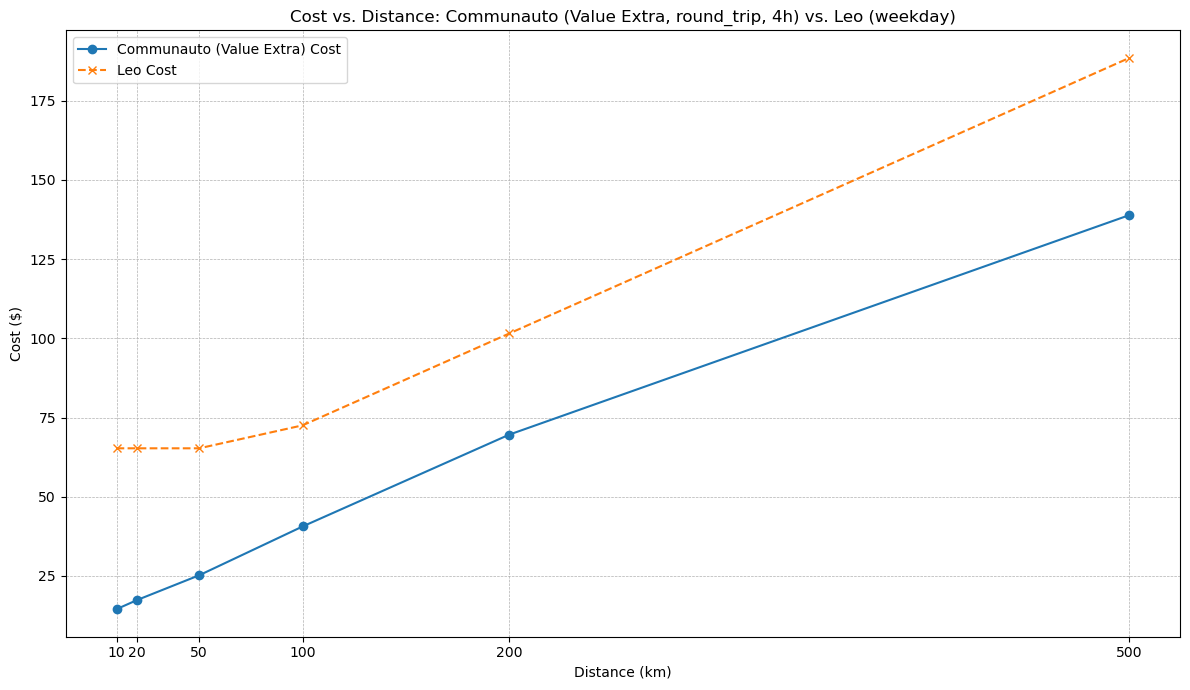


--- Generating Graph 2: Winner Heatmap ---


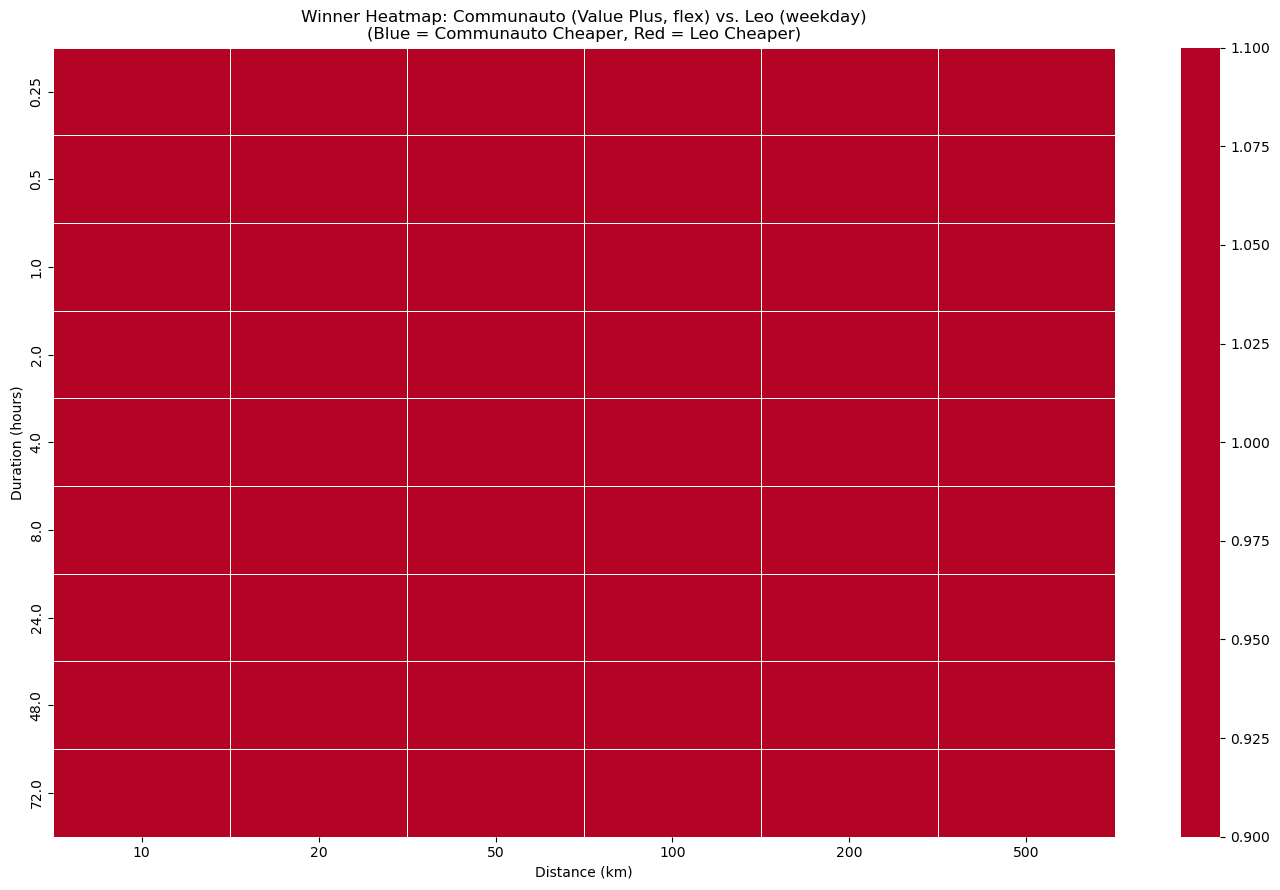


--- Generating Graph 3: Multi-Plan Cost vs. Distance ---


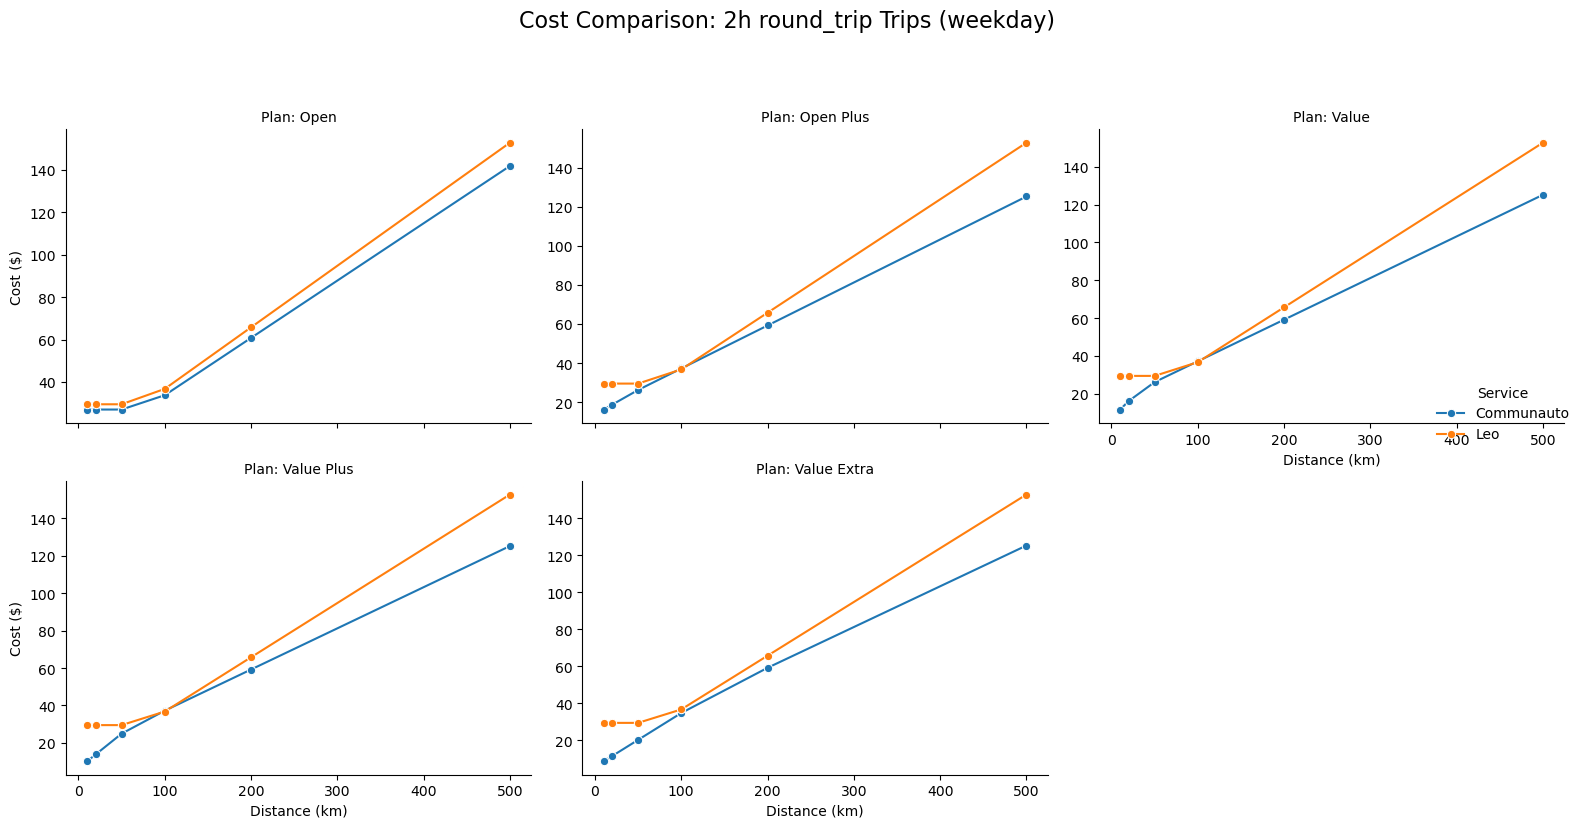

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Just in case it's not imported in the current scope

# Ensure df_results is available (it should be if the previous cell ran)
if 'df_results' not in locals():
    print("Error: df_results DataFrame not found. Please run the data generation script first.")
else:
    print(f"df_results contains {len(df_results)} rows. Proceeding with plotting.")

    # --- Graph 1: Cost Comparison for a Specific Scenario (e.g., Value Extra, Round-Trip, Weekday, 4 hours duration) ---
    print("\n--- Generating Graph 1: Cost vs. Distance for a Specific Scenario ---")
    plan_to_plot_g1 = 'Value Extra'
    trip_type_to_plot_g1 = 'round_trip'
    day_type_to_plot_g1 = 'weekday'
    duration_to_plot_g1 = 4 # hours

    subset_g1 = df_results[
        (df_results['communauto_plan'] == plan_to_plot_g1) &
        (df_results['cm_trip_type'] == trip_type_to_plot_g1) &
        (df_results['day_type'] == day_type_to_plot_g1) &
        (df_results['duration_h'] == duration_to_plot_g1)
    ]

    if not subset_g1.empty:
        plt.figure(figsize=(12, 7))
        plt.plot(subset_g1['distance_km'], subset_g1['cm_cost'], label=f'Communauto ({plan_to_plot_g1}) Cost', marker='o', linestyle='-')
        plt.plot(subset_g1['distance_km'], subset_g1['leo_cost'], label='Leo Cost', marker='x', linestyle='--')
        
        plt.xlabel('Distance (km)')
        plt.ylabel('Cost ($)')
        plt.title(f'Cost vs. Distance: Communauto ({plan_to_plot_g1}, {trip_type_to_plot_g1}, {duration_to_plot_g1}h) vs. Leo ({day_type_to_plot_g1})')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xticks(subset_g1['distance_km'].unique()) # Ensure all plotted distances are ticks
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data for Graph 1 with parameters: Plan={plan_to_plot_g1}, TripType={trip_type_to_plot_g1}, Day={day_type_to_plot_g1}, Duration={duration_to_plot_g1}h.")

    # --- Graph 2: Winner Heatmap for a Specific Communauto Plan & Trip Type ---
    print("\n--- Generating Graph 2: Winner Heatmap ---")
    plan_to_plot_g2 = 'Value Plus'
    trip_type_to_plot_g2 = 'flex'
    day_type_to_plot_g2 = 'weekday' # Ensure this matches data in df_results

    subset_for_heatmap = df_results[
        (df_results['communauto_plan'] == plan_to_plot_g2) &
        (df_results['cm_trip_type'] == trip_type_to_plot_g2) &
        (df_results['day_type'] == day_type_to_plot_g2)
    ].copy()

    if not subset_for_heatmap.empty:
        # Create a numerical representation for the winner
        # 1 for Communauto, -1 for Leo, 0 for potential tie (though unlikely with float costs)
        subset_for_heatmap['winner_numeric'] = subset_for_heatmap.apply(
            lambda row: 1 if row['winner'] == 'Communauto' else -1 if row['winner'] == 'Leo' else 0, axis=1
        )
        
        try:
            pivot_table = subset_for_heatmap.pivot_table(
                values='winner_numeric',
                index='duration_h',
                columns='distance_km'
            )

            plt.figure(figsize=(14, 9))
            # cmap "coolwarm" is good for diverging: blue for one extreme, red for other, white for middle
            # Or "RdYlGn" for Red-Yellow-Green
            sns.heatmap(pivot_table, annot=False, cmap="coolwarm", center=0, linewidths=.5)
            plt.title(f'Winner Heatmap: Communauto ({plan_to_plot_g2}, {trip_type_to_plot_g2}) vs. Leo ({day_type_to_plot_g2})'
                      f'\n(Blue = Communauto Cheaper, Red = Leo Cheaper)')
            plt.xlabel('Distance (km)')
            plt.ylabel('Duration (hours)')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not generate heatmap for Plan={plan_to_plot_g2}, TripType={trip_type_to_plot_g2}. Error: {e}")
            print("Pivot table might be empty or have issues. Data sample for this subset:")
            print(subset_for_heatmap.head())

    else:
        print(f"No data for Heatmap Graph 2 with parameters: Plan={plan_to_plot_g2}, TripType={trip_type_to_plot_g2}, Day={day_type_to_plot_g2}.")


    # --- Graph 3: FacetGrid to show multiple plan comparisons (Cost vs Distance for a fixed duration) ---
    print("\n--- Generating Graph 3: Multi-Plan Cost vs. Distance ---")
    fixed_duration_g3 = 2 # hours
    fixed_trip_type_g3 = 'round_trip'
    fixed_day_type_g3 = 'weekday'

    subset_g3 = df_results[
        (df_results['duration_h'] == fixed_duration_g3) &
        (df_results['cm_trip_type'] == fixed_trip_type_g3) &
        (df_results['day_type'] == fixed_day_type_g3)
    ]

    if not subset_g3.empty:
        # Melt the DataFrame to have 'cost_type' (Communauto or Leo) and 'cost_value' columns
        melted_df_g3 = subset_g3.melt(
            id_vars=['communauto_plan', 'distance_km'],
            value_vars=['cm_cost', 'leo_cost'],
            var_name='cost_source',
            value_name='cost'
        )
        melted_df_g3['cost_source'] = melted_df_g3['cost_source'].replace({'cm_cost': 'Communauto', 'leo_cost': 'Leo'})

        g = sns.FacetGrid(melted_df_g3, col="communauto_plan", col_wrap=3, height=4, aspect=1.2, sharey=False)
        g.map_dataframe(sns.lineplot, x="distance_km", y="cost", hue="cost_source", marker="o")
        g.set_axis_labels("Distance (km)", "Cost ($)")
        g.set_titles("Plan: {col_name}")
        g.add_legend(title="Service")
        g.fig.suptitle(f'Cost Comparison: {fixed_duration_g3}h {fixed_trip_type_g3} Trips ({fixed_day_type_g3})', y=1.03, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make space for suptitle
        plt.show()
    else:
        print(f"No data for FacetGrid Graph 3 with Duration={fixed_duration_g3}h, TripType={fixed_trip_type_g3}, Day={fixed_day_type_g3}.")

Calculating prices for Use Case: A. Plateau Coffee & Bagels (Weekend Morning, FLEX)
Calculating prices for Use Case: B. IKEA Run (Weekday Afternoon, longer duration, low KM)
Calculating prices for Use Case: C. Evening Out Downtown (Dinner & Show, one-way potential)
Calculating prices for Use Case: D. Multiple Errands Loop (Mid-day Weekday, Round-Trip)
Calculating prices for Use Case: E. Visiting Friends Across Town (Weekend, medium duration & KM)
Calculating prices for Use Case: F. Quick Airport Drop-off (FLEX one-way)
Calculating prices for Use Case: G. Day Trip to Mont-Tremblant (Longer duration, higher KM)
Calculating prices for Use Case: H. Workday Special Candidate (Value Extra Only, Urban)


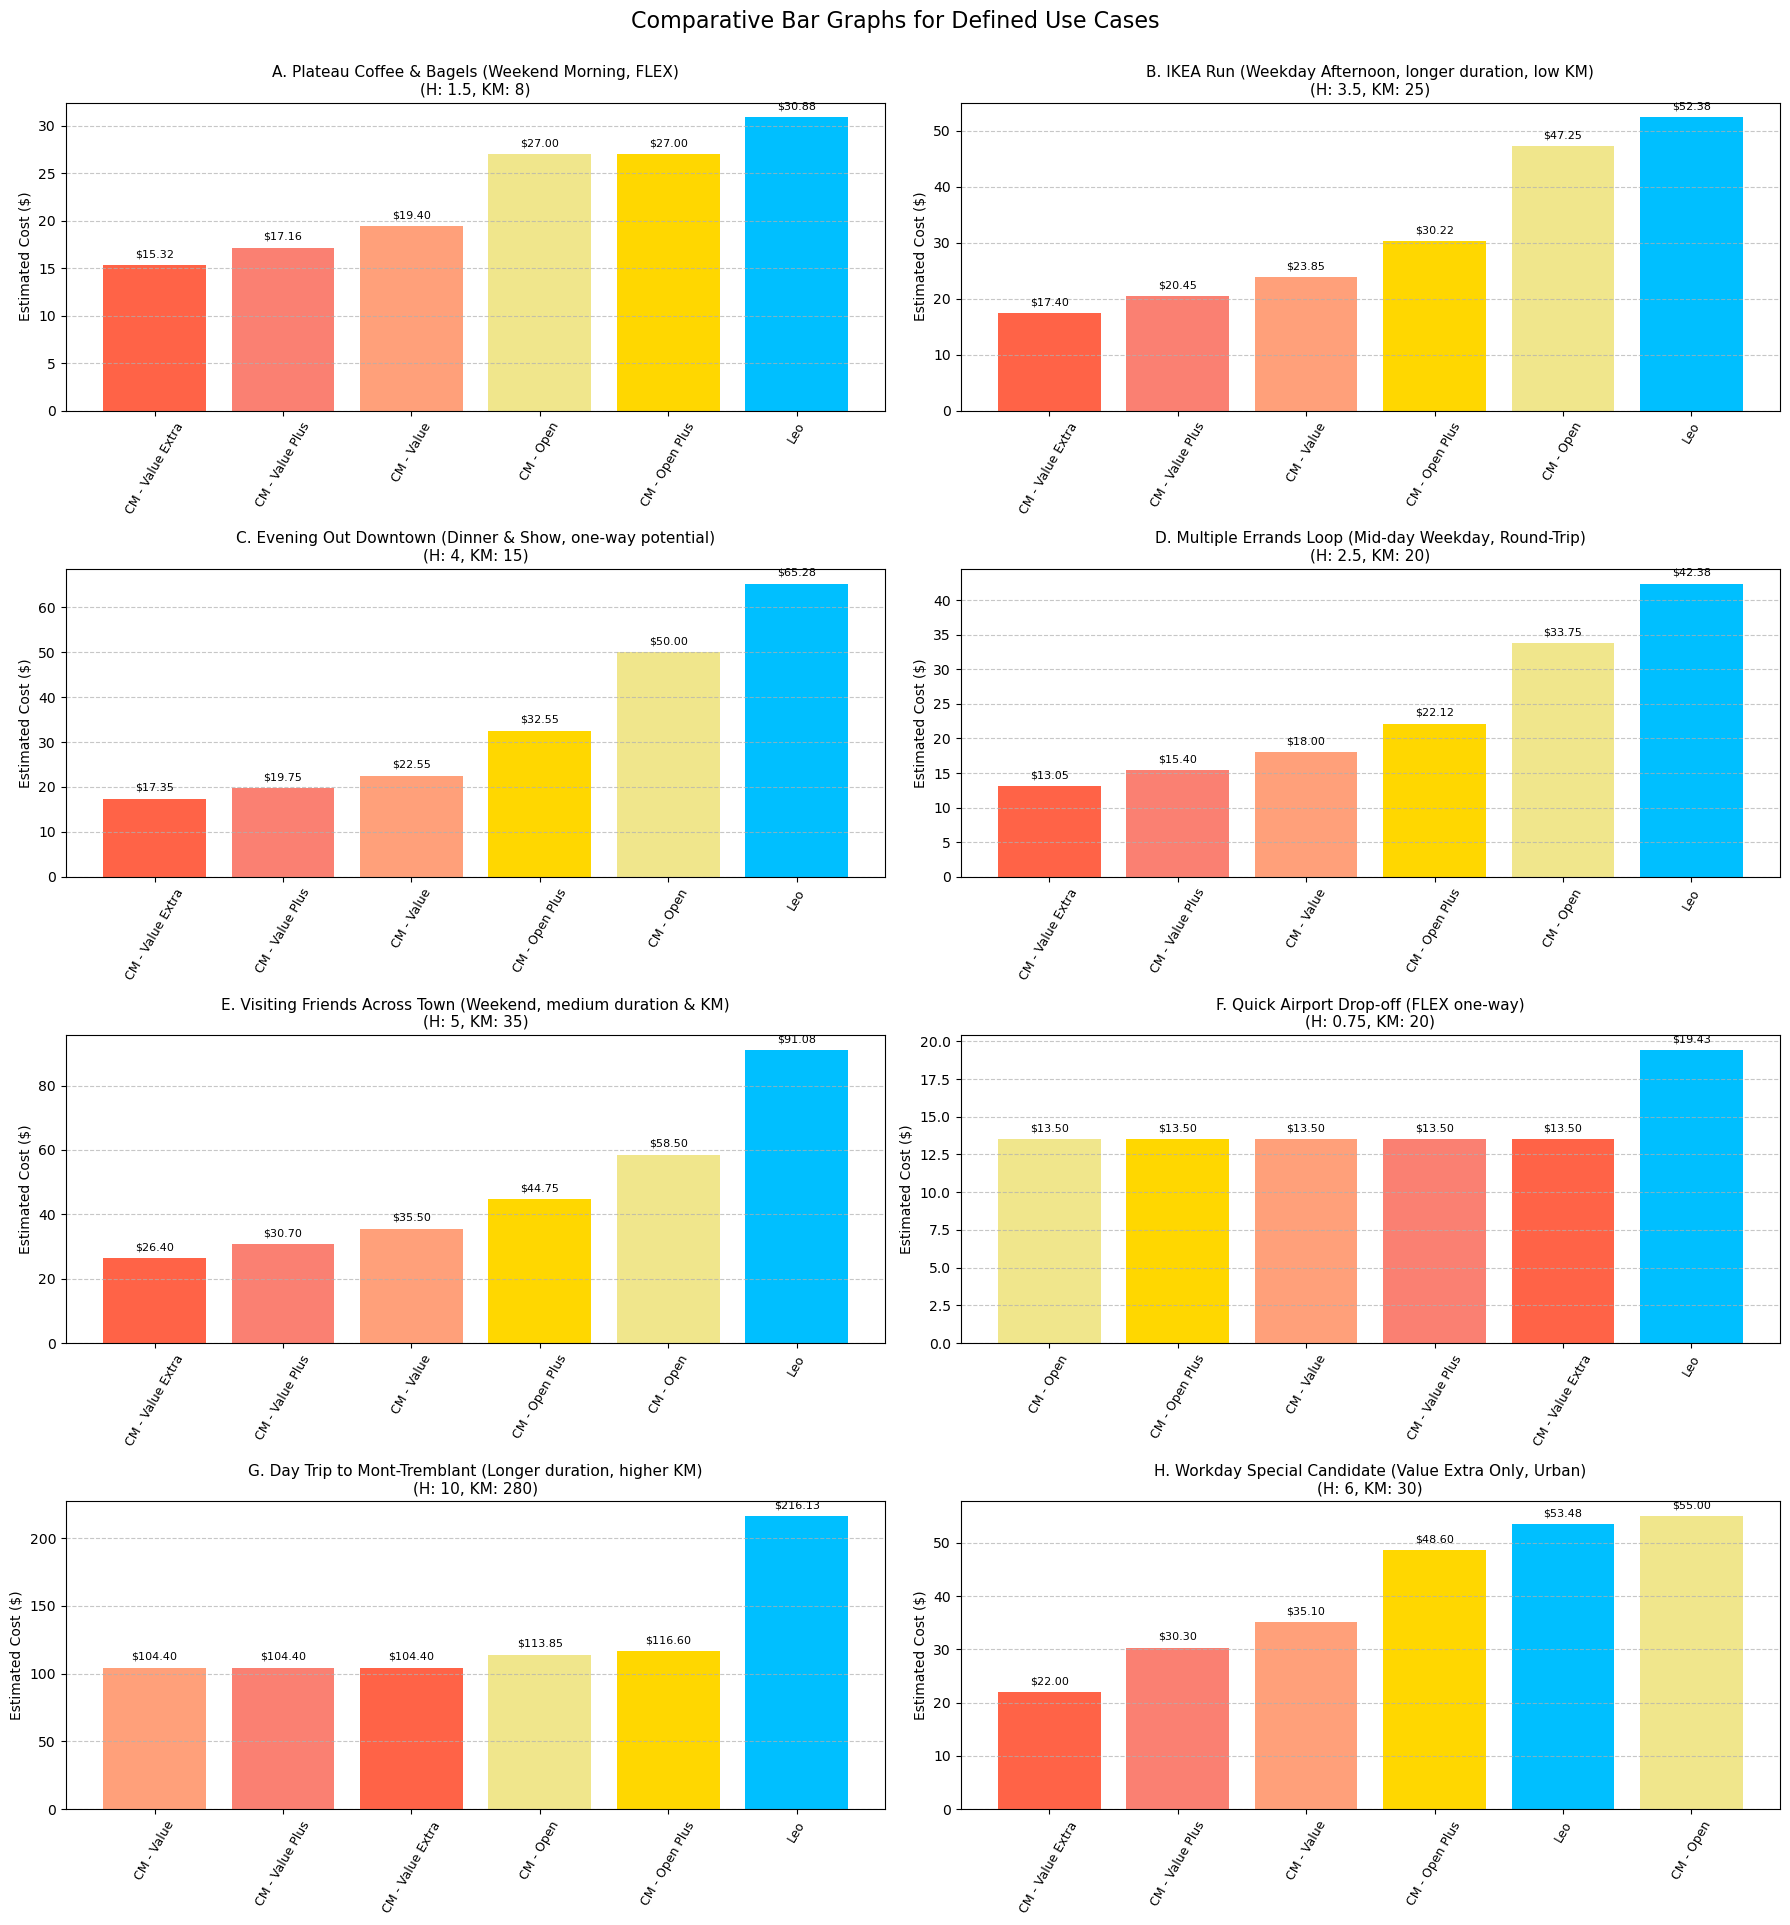

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # For bar positioning
from datetime import datetime # For potential trip_start_date_cm

# --- PASTE YOUR CommunautoPricer and LeoPricer CLASS DEFINITIONS HERE ---
# --- AND THE COMMUNAUTO_PLANS, etc. CONSTANTS IF NOT IN A PREVIOUS CELL ---
# For brevity, I'm assuming they are already defined in your notebook.
# If not, you MUST include them before this plotting code.

# Example placeholder for constants if you need to define them here:
# COMMUNAUTO_PLANS = { "Open": {...}, ... } # Your full plans dictionary
# class CommunautoPricer: ...
# class LeoPricer: ...


# --- 1. Define Use Cases ---
# --- More Montreal-Relevant Use Cases ---
use_cases = {
    "A. Plateau Coffee & Bagels (Weekend Morning, FLEX)": {
        "total_hours": 1.5, "km": 8, "is_saturday_sunday": True, "is_weekday": False,
        "cm_trip_type": "flex", # Grab a car, quick stops, leave it.
        "leo_equivalent_params": {"total_hours": 1.5, "km": 8}
    },
    "B. IKEA Run (Weekday Afternoon, longer duration, low KM)": {
        "total_hours": 3.5, "km": 25, "is_saturday_sunday": False, "is_weekday": True,
        "cm_trip_type": "round_trip", # Need it for a block of time, will return.
        "leo_equivalent_params": {"total_hours": 3.5, "km": 25}
    },
    "C. Evening Out Downtown (Dinner & Show, one-way potential)": {
        "total_hours": 4, "km": 15, "is_saturday_sunday": True, "is_weekday": False, # Assuming a weekend evening
        "cm_trip_type": "flex", # Drive there, take a taxi/metro back, or vice-versa.
        "leo_equivalent_params": {"total_hours": 4, "km": 15}
    },
    "D. Multiple Errands Loop (Mid-day Weekday, Round-Trip)": {
        "total_hours": 2.5, "km": 20, "is_saturday_sunday": False, "is_weekday": True,
        "cm_trip_type": "round_trip", # Post office, bank, grocery store - need car for the duration.
        "leo_equivalent_params": {"total_hours": 2.5, "km": 20}
    },
    "E. Visiting Friends Across Town (Weekend, medium duration & KM)": {
        "total_hours": 5, "km": 35, "is_saturday_sunday": True, "is_weekday": False,
        "cm_trip_type": "round_trip", # Likely a planned visit.
        "leo_equivalent_params": {"total_hours": 5, "km": 35}
    },
    "F. Quick Airport Drop-off (FLEX one-way)": {
        # Duration can vary with traffic, but often under an hour for the drive itself
        "total_hours": 0.75, "km": 20, "is_saturday_sunday": False, "is_weekday": True, # Example weekday
        "cm_trip_type": "flex",
        "leo_equivalent_params": {"total_hours": 0.75, "km": 20}
    },
    # Keep a couple of longer ones for contrast if desired, or focus entirely on urban
    "G. Day Trip to Mont-Tremblant (Longer duration, higher KM)": {
        "total_hours": 10, "km": 280, "is_saturday_sunday": True, "is_weekday": False,
        "cm_trip_type": "round_trip",
        "leo_equivalent_params": {"total_hours": 10, "km": 280}
    },
    "H. Workday Special Candidate (Value Extra Only, Urban)": {
        "total_hours": 6, "km": 30, "is_saturday_sunday": False, "is_weekday": True,
        "cm_trip_type": "round_trip",
        "leo_equivalent_params": {"total_hours": 6, "km": 30}
    }
}

# --- 2. Function to get prices for a use case ---
def get_use_case_prices(use_case_params, use_case_name_for_logic=""):
    prices = []
    # Ensure Pricer classes are accessible; if not defined globally, instantiate here or pass them
    # This example assumes they are defined globally in the notebook scope.
    try:
        leo_pricer = LeoPricer()
    except NameError:
        print("ERROR: LeoPricer class not defined. Please define it before running this script.")
        return pd.DataFrame() # Return empty DataFrame

    leo_cost_data = leo_pricer.calculate_cost(
        total_hours=use_case_params["leo_equivalent_params"]["total_hours"],
        km=use_case_params["leo_equivalent_params"]["km"]
    )
    prices.append({
        "service_plan": "Leo",
        "cost": leo_cost_data["final_cost"],
        "method": leo_cost_data["method"]
    })

    try:
        communauto_plan_keys = list(COMMUNAUTO_PLANS.keys())
    except NameError:
        print("ERROR: COMMUNAUTO_PLANS constant not defined.")
        return pd.DataFrame(prices) # Return with Leo data only if CM plans missing

    for plan_name in communauto_plan_keys:
        if use_case_name_for_logic == "7. Workday Special (Value Extra Only)" and plan_name != "Value Extra":
            continue

        try:
            cm_pricer = CommunautoPricer(plan_name=plan_name) # Assuming standard vehicle type
        except NameError:
            print(f"ERROR: CommunautoPricer class not defined. Skipping Communauto for {plan_name}.")
            continue
        
        use_flex_pass = use_case_params.get("use_flex_pass_cm", False)
        trip_start_date = use_case_params.get("trip_start_date_cm", datetime.now())

        cm_cost_data = cm_pricer.get_best_price(
            trip_type=use_case_params["cm_trip_type"],
            total_hours=use_case_params["total_hours"],
            km=use_case_params["km"],
            is_saturday_sunday=use_case_params["is_saturday_sunday"],
            is_weekday=use_case_params["is_weekday"],
            use_flex_pass=use_flex_pass,
            trip_start_date=trip_start_date
        )
        prices.append({
            "service_plan": f"CM - {plan_name}",
            "cost": cm_cost_data["final_cost"],
            "method": cm_cost_data["method"]
        })
    return pd.DataFrame(prices)

# --- 3. Plotting ---
if not use_cases:
    print("No use cases defined. Skipping plotting.")
else:
    num_use_cases = len(use_cases)
    # Adjust nrows and ncols for better layout if many use cases
    ncols = 2  # Try 2 columns
    nrows = (num_use_cases + ncols - 1) // ncols # Calculate rows needed
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9 * ncols, 5 * nrows), squeeze=False)
    axes_flat = axes.flatten() # Flatten to easily iterate

    for i, (use_case_name, params) in enumerate(use_cases.items()):
        print(f"Calculating prices for Use Case: {use_case_name}")
        df_use_case_prices = get_use_case_prices(params, use_case_name_for_logic=use_case_name)
        
        if df_use_case_prices.empty:
            print(f"No pricing data generated for {use_case_name}. Skipping plot.")
            if i < len(axes_flat): # Hide unused subplot if data is missing
                 axes_flat[i].axis('off')
            continue

        ax = axes_flat[i]
        
        df_use_case_prices = df_use_case_prices.sort_values(by="cost")
        
        bar_colors = []
        for sp in df_use_case_prices["service_plan"]:
            if 'Leo' in sp:
                bar_colors.append('deepskyblue')
            elif 'Value Extra' in sp:
                bar_colors.append('tomato')
            elif 'Value Plus' in sp:
                bar_colors.append('salmon')
            elif 'Value' in sp:
                bar_colors.append('lightsalmon')
            elif 'Open Plus' in sp:
                bar_colors.append('gold')
            elif 'Open' in sp:
                bar_colors.append('khaki')
            else:
                bar_colors.append('lightgray')


        bars = ax.bar(df_use_case_prices["service_plan"], df_use_case_prices["cost"], color=bar_colors)
        
        ax.set_ylabel("Estimated Cost ($)")
        ax.set_title(f"{use_case_name}\n(H: {params['total_hours']}, KM: {params['km']})", fontsize=11)
        ax.tick_params(axis='x', rotation=60, labelsize=9)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        max_cost_for_offset = 0
        if not df_use_case_prices["cost"].empty: # Check if 'cost' series is not empty
            max_cost_for_offset = df_use_case_prices["cost"].max() if pd.notna(df_use_case_prices["cost"].max()) else 1 # Default if all NaN
        
        for bar in bars:
            yval = bar.get_height()
            if pd.notna(yval): # Ensure yval is not NaN before formatting
                 ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02 * max_cost_for_offset,
                        f"${yval:.2f}", ha='center', va='bottom', fontsize=8, rotation=0)

    # Hide any unused subplots if num_use_cases is not a perfect multiple for grid
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Add space at bottom for rotated x-labels and top for suptitle
    fig.suptitle("Comparative Bar Graphs for Defined Use Cases", fontsize=16, y=0.99)
    plt.show()

In [6]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Create a directory to save the images if it doesn't already exist
output_dir = "graphs"
os.makedirs(output_dir, exist_ok=True)

if not use_cases:
    print("No use cases defined. Skipping saving graphs.")
else:
    for use_case_name, params in use_cases.items():
        print(f"Calculating prices for Use Case: {use_case_name}")
        df_use_case_prices = get_use_case_prices(params, use_case_name_for_logic=use_case_name)
        
        if df_use_case_prices.empty:
            print(f"No pricing data generated for {use_case_name}. Skipping plot.")
            continue

        # Create a new figure for each use case
        plt.figure(figsize=(9, 5))
        
        df_use_case_prices = df_use_case_prices.sort_values(by="cost")
        
        bar_colors = []
        for sp in df_use_case_prices["service_plan"]:
            if 'Leo' in sp:
                bar_colors.append('deepskyblue')
            elif 'Value Extra' in sp:
                bar_colors.append('tomato')
            elif 'Value Plus' in sp:
                bar_colors.append('salmon')
            elif 'Value' in sp:
                bar_colors.append('lightsalmon')
            elif 'Open Plus' in sp:
                bar_colors.append('gold')
            elif 'Open' in sp:
                bar_colors.append('khaki')
            else:
                bar_colors.append('lightgray')

        bars = plt.bar(df_use_case_prices["service_plan"], df_use_case_prices["cost"], color=bar_colors)
        
        plt.ylabel("Estimated Cost ($)")
        plt.title(f"{use_case_name}\n(H: {params['total_hours']}, KM: {params['km']})", fontsize=11)
        plt.xticks(rotation=60, fontsize=9)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        max_cost_for_offset = 0
        if not df_use_case_prices["cost"].empty:
            max_cost_for_offset = df_use_case_prices["cost"].max() if pd.notna(df_use_case_prices["cost"].max()) else 1
        
        for bar in bars:
            yval = bar.get_height()
            if pd.notna(yval):
                plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02 * max_cost_for_offset,
                        f"${yval:.2f}", ha='center', va='bottom', fontsize=8, rotation=0)

        plt.tight_layout()
        
        # Save each individual graph
        graph_filename = os.path.join(output_dir, f"{use_case_name.replace(' ', '_').replace('.', '').replace('/', '_')}.png")
        plt.savefig(graph_filename, bbox_inches='tight')
        print(f"Saved graph for '{use_case_name}' as {graph_filename}")
        
        # Close the figure to free up memory
        plt.close()

Calculating prices for Use Case: A. Plateau Coffee & Bagels (Weekend Morning, FLEX)
Saved graph for 'A. Plateau Coffee & Bagels (Weekend Morning, FLEX)' as graphs/A_Plateau_Coffee_&_Bagels_(Weekend_Morning,_FLEX).png
Calculating prices for Use Case: B. IKEA Run (Weekday Afternoon, longer duration, low KM)
Saved graph for 'B. IKEA Run (Weekday Afternoon, longer duration, low KM)' as graphs/B_IKEA_Run_(Weekday_Afternoon,_longer_duration,_low_KM).png
Calculating prices for Use Case: C. Evening Out Downtown (Dinner & Show, one-way potential)
Saved graph for 'C. Evening Out Downtown (Dinner & Show, one-way potential)' as graphs/C_Evening_Out_Downtown_(Dinner_&_Show,_one-way_potential).png
Calculating prices for Use Case: D. Multiple Errands Loop (Mid-day Weekday, Round-Trip)
Saved graph for 'D. Multiple Errands Loop (Mid-day Weekday, Round-Trip)' as graphs/D_Multiple_Errands_Loop_(Mid-day_Weekday,_Round-Trip).png
Calculating prices for Use Case: E. Visiting Friends Across Town (Weekend, med